In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
#export
from exp.nb_04 import *

## Initial setup

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7013)

In [4]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [5]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [6]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [7]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.6638009375, tensor(0.8076)]
valid: [0.3031380126953125, tensor(0.9137)]
train: [0.289829609375, tensor(0.9158)]
valid: [0.2321001708984375, tensor(0.9335)]
train: [0.23581904296875, tensor(0.9316)]
valid: [0.2058675048828125, tensor(0.9422)]


In [8]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.7582815625, tensor(0.8135)]
valid: [0.345248779296875, tensor(0.9059)]
train: [0.343613046875, tensor(0.9010)]
valid: [0.2888345458984375, tensor(0.9179)]
train: [0.296436171875, tensor(0.9143)]
valid: [0.253634423828125, tensor(0.9296)]


In [9]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

In order to get a good model, the first layer is super important. In order to get this right, we use annealing. High level explanation of annealing is here: https://medium.com/@macromoltek/machine-learning-and-simulated-annealing-588b2e70d0cc

## Annealing

We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer. 

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7202)

In [10]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback): # this is used for hyper parameter scheduling. We might want to change the hyper parameter values across different layers. In this eg, our hyperparm is the LR.
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups: # param groups are introduced in pytorch to be able to set different values of hyperparams across different groups thereby at different layers
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

Let's start with a simple linear schedule going from start to end. It returns a function that takes a `pos` argument (going from 0 to 1) such that this function goes from `start` (at `pos=0`) to `end` (at `pos=1`) in a linear fashion.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7431)

In [11]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

We can refactor this with a decorator.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7526)

In [13]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer # a decorator is a function that takes another function and extends the behavior of the latter function without explicitly modifying it. In this case, sched_lin will be extended by annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [14]:
# shift-tab works too, in Jupyter!
sched_lin??

Signature: sched_lin(start, end)
Docstring: <no docstring>
Source:        def _inner(start, end): return partial(f, start, end)
File:      ~/VirtualEnv/fastai/course-v3/nbs/dl2/<ipython-input-13-044b12665f8a>
Type:      function


In [15]:
f = sched_lin(1,2)
f(0.3)

1.3

And here are other scheduler functions:

In [19]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

# NOTE: PyTorch Tensors cannot be plotted because they don't provide the ndim property so we will override it. Hence, this monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape)) # PYTHON BEAUTY!

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7730)

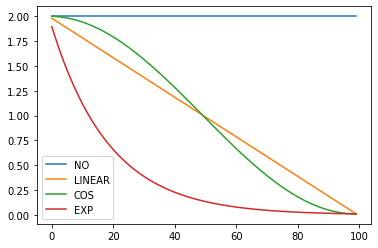

In [18]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In practice, we'll often want to combine different schedulers, the following function does that: it uses `scheds[i]` for `pcts[i]` of the training.

In [24]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    # print(pcts)
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

Here is an example: use 30% of the budget to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

In [25]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

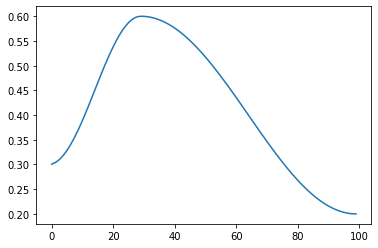

In [26]:
plt.plot(a, [sched(o) for o in p])

We can use it for training quite easily...
The consine scheduling learning rate works really well because you need to train at a high LR for a long time. but we also need to fine tune at a low LR for a long time, so that's what the cosine curve helps to change the LR.

In [27]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [28]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [29]:
run.fit(3, learn)

train: [0.78007359375, tensor(0.7854)]
valid: [0.3471561767578125, tensor(0.8942)]
train: [0.3064387890625, tensor(0.9089)]
valid: [0.2378677490234375, tensor(0.9333)]
train: [0.24313693359375, tensor(0.9302)]
valid: [0.2160984130859375, tensor(0.9396)]


... then check with our recorder if the learning rate followed the right schedule.

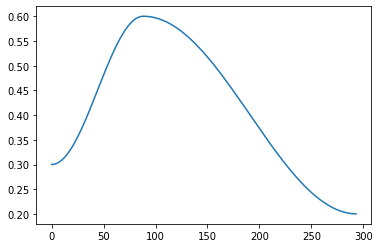

In [30]:
run.recorder.plot_lr()

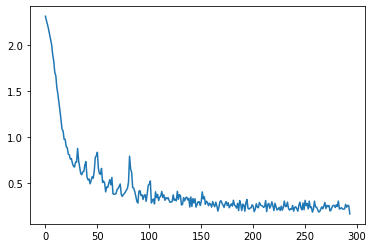

In [31]:
run.recorder.plot_loss()

## Export

In [ ]:
!./notebook2script.py 05_anneal.ipynb

Converted 05_anneal.ipynb to nb_05.py
